# BN16

Playground for the bn16 dataset.

## Imports

In [1]:
#!TMPDIR=../../tmp pip install torch==1.7.* torch-summary numpy pandas matplotlib sparse ipywidgets

In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchsummary import summary
import sparse
from torch.utils.data import Dataset, DataLoader, random_split
from torch.cuda.amp import autocast

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import MaxNLocator
import os
from timeit import default_timer as timer
import datetime
import glob

from ipywidgets import interact, interactive
import ipywidgets

import gc

## Config

In [3]:
# DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')

print(DEVICE)
RND_SEED = 1
BATCH_SIZE = 8
N_STEPS = 12
N_INDIVIDUALS = 2443

torch.random.manual_seed(RND_SEED)
torch.cuda.manual_seed(RND_SEED)

pd.options.display.max_rows = 20
pd.options.display.min_rows = None
pd.options.display.width = 800
np.set_printoptions(edgeitems=5)
np.core.arrayprint._line_width = 300

cuda:1


# Data



The data has dimensions $I \times I \times D \times T$, with $I \times I$ being the individuals interactions matrix, $D$ being the day of observation and $T$ being the time of the snapshot (48 times half an hour). The actual dimensions are $2443 \times 2443 \times 56 \times 48$.

That means that we have sequences of length $56 \cdot 48 = 2688$ (in time). The life span of the individuals depends on their tasks and individual factors.

## File Chunking

Transform into daily chunks with dimensions: time x I x I where time is 48x half an hour and I is the individual.

## Additional Data

### Aliveness

In [4]:
observation_start_date = datetime.datetime(2016, 7, 23, 0, 0, 0, 0)
hatching_start_date = datetime.datetime(2016, 7, 19, 0, 0, 0, 0)

In [5]:
indices_data = pd.read_csv('indices_bn16.csv').sort_values(by='bee_id')
alive_data = pd.read_csv('alive_bn16.csv').sort_values(by='bee_id')

In [6]:
# combine both
combined_alive_data = alive_data
combined_alive_data['interaction_matrix_idx'] = indices_data['interaction_matrix_idx']
# now sort by matrix id for easy vector generation
combined_alive_data = combined_alive_data.sort_values(by='interaction_matrix_idx')
# date column type fix
combined_alive_data['date_emerged'] = pd.to_datetime(combined_alive_data['date_emerged'])
# let's translate the hatch day into a step where observation_start_date is step 0
combined_alive_data['born_in_step'] = combined_alive_data['date_emerged'].map(lambda x: (x - observation_start_date).days * 48)
combined_alive_data['dead_by_step'] = combined_alive_data.apply(lambda row: 48 * row['days_alive'] + row['born_in_step'], axis=1)
# combined_alive_data = get_combined_alive_data(indices_data, alive_data, observation_start_date)
combined_alive_data

,bee_id,date_emerged,days_alive,interaction_matrix_idx,born_in_step,dead_by_step
0,9,2016-07-19,5,0,-192,48
1,10,2016-07-19,16,1,-192,576
2,17,2016-07-19,4,2,-192,0
3,21,2016-07-19,35,3,-192,1488
4,22,2016-07-19,19,4,-192,720
5,37,2016-07-19,15,5,-192,528
6,38,2016-07-19,8,6,-192,192
7,40,2016-07-19,14,7,-192,480
8,43,2016-07-19,18,8,-192,672
9,44,2016-07-19,24,9,-192,960


For data insights like age distribution take a look at the `insights` notebook.

#### Util

In [7]:
def bee_id_to_matrix_id(bee_id, index_data):
    '''Translates the bee ID into the matrix ID.'''
    return indices_data[indices_data['bee_id'] == bee_id]['interaction_matrix_idx'].item()

def matrix_id_to_bee_id(matrix_id):
    '''Translates the matrix ID into the bee ID.'''
    return indices_data[indices_data['interaction_matrix_idx'] == matrix_id]['bee_id'].item()

def get_aliveness_vector(step):
    '''Returns a #individuals-long boolean vector of matrix-ID-indexed bee aliveness.'''
    return (combined_alive_data['born_in_step'] <= step) & (step < combined_alive_data['dead_by_step'])

def get_lifespan_for_row(row, step):
    if ((step < row['born_in_step']) | (row['dead_by_step'] < step)): #iloc[0] if you pass in a df
        return 0
    return row['dead_by_step'] - step  #iloc[0] if you pass in a df    

def get_lifespan_vector(step):
    '''Returns a #individuals-long vector of matrix-ID-indexed remaining bee lifespans in steps (half an hour).'''
    return combined_alive_data.apply(get_lifespan_for_row, axis=1, step=step)

def get_lifespan_for_individual(midx):
    '''Get the remaining steps to live for given individual matrix index.'''
    # start at zero, not before
    bis = max(combined_alive_data[combined_alive_data['interaction_matrix_idx'] == midx]['born_in_step'].item(), 0)
    dis = combined_alive_data.iloc[midx]['dead_by_step']
    # full range, 56 days à 48 steps
    r = np.zeros(56 * 48) 
    # dead in 4 steps => 4,3,2,1 - clip to length
    ins = np.arange(dis - bis)[::-1][:len(r) - bis] 
    r[bis:bis + len(ins)] = ins
    return r

### Circadian Rhythmicity

In [8]:
circadian_data = pd.read_csv(
    'rhythmicity_bn16.csv',
    dtype={'bee_id': np.int16, 'age': np.int8, 'date': str, 'circadian_rhythmicity': np.float64},
    parse_dates=['date'],
    date_parser = pd.to_datetime
)
circadian_data[0:5]

,bee_id,age,date,circadian_rhythmicity
0,960,7,2016-07-26,0.025426
1,1126,7,2016-07-26,0.022645
2,1519,6,2016-07-26,0.002309
3,1527,7,2016-07-26,0.002183
4,1529,7,2016-07-26,0.009352


In [9]:
# we need to expand the days into 48 copies, also, we don't know if there are gaps in the date so we should not rely on the date to be continous
def circadian_vector_for_individual(bee_id, circadian, observation_start_date):
    '''Get the vector of circadian rhythmicity per step for a bee.
    
    Parameters
    ----------
    bee_id : int
        The ID of the bee.
    circadian : pd.DataFrame
        The data frame with the circadian rhythmicities.
    observation_start_date: datetime
        The datetime of observation start.
    '''
    v = np.zeros(56 * 48)
    for row in circadian[circadian['bee_id'] == bee_id].itertuples():
        ins_start = (row.date - observation_start_date).days * 48
        v[ins_start:ins_start + 48] = np.repeat(row.circadian_rhythmicity, 48)
    return v

## Data Set

In [10]:
class OneDayDataSet(Dataset):
    '''Holds one complete day of the network.'''
    def __init__(self, day, transform=None):
        self.data = sparse.load_npz('daily/{}.npz'.format(day))
        self.transform = transform
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        d = torch.from_numpy(self.data[idx].todense())
        if self.transform:
            d = self.transform(d)
        return d

In [11]:
class IndividualDataSet(Dataset):
    '''Holds the data for one individual.'''
    def __init__(self, day, transform=None):
        self.data = sparse.load_npz('individuals/{}.npz'.format(day))
        self.transform = transform
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        d = torch.from_numpy(self.data[idx].todense())
        if self.transform:
            d = self.transform(d)
        return d

In [12]:
class Bn16DataSet(Dataset):
    def __init__(self, days=(0, 56), transform=None):
        self.days = days
        self.transform = transform
        
    def __len__(self):
        return 2443
    
    def __getitem__(self, idx):        
        d = sparse.load_npz('individuals/{}.npz'.format(idx))
        d = d[self.days[0] * 48:self.days[1] * 48]
        d = torch.from_numpy(d.todense().astype(np.float32))
        if self.transform:
            d = self.transform(d)
        return (
            d,
            {
                'lifespan': get_lifespan_for_individual(idx).astype('float'),
                'circadian': circadian_vector_for_individual(
                    matrix_id_to_bee_id(idx),
                    circadian_data,
                    observation_start_date
                ).astype('float')
            }
        )

### Split & Loaders

In [13]:
# first 36 days
bn16_data = Bn16DataSet(days=(0, 35))
len(bn16_data)

2443

In [14]:
# 80/20 split
train_data, test_data = random_split(bn16_data, [1955, 488])

#### TODO: write a collator that strips tail zero sequences, reduce dim via max(), find and cut tails, pad_sequence with 0 to same length

full_loader = DataLoader(
    bn16_data
    ,batch_size=BATCH_SIZE
    ,shuffle=True
    ,num_workers=4
    #,collate_fn=subsample
    ,drop_last=True
)
train_loader = DataLoader(
    train_data
    ,batch_size=BATCH_SIZE
    ,shuffle=True
    ,num_workers=4
    #,collate_fn=subsample
    ,drop_last=True
)
test_loader = DataLoader(
    test_data
    ,batch_size=BATCH_SIZE
    ,shuffle=True
    ,num_workers=2
    #,collate_fn=subsample
    ,drop_last=True
)

In [15]:
for idx, (x, y) in enumerate(train_loader):
    print(idx, x.shape, y)
    break

0 torch.Size([8, 1680, 2443]) {'lifespan': tensor([[ 143.,  142.,  141.,  ...,    0.,    0.,    0.],
        [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
        [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
        ...,
        [1775., 1774., 1773.,  ...,    0.,    0.,    0.],
        [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
        [   0.,    0.,    0.,  ...,    0.,    0.,    0.]], dtype=torch.float64), 'circadian': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.1023, 0.1023, 0.1023],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64)}


In [16]:
len(full_loader), len(train_loader), len(test_loader)

(305, 244, 61)

# Model

In [17]:
class CPC(nn.Module):
    def __init__(self, n_steps, batch_size, hidden_size=256, context_size=256):
        super(CPC, self).__init__()
        self.n_steps = n_steps
        self.hidden_size = hidden_size
        self.context_size = context_size
        self.g_enc = self.encoder()
        self.g_ar = self.autoregressive()
        self.step_W = nn.ModuleList([nn.Linear(self.context_size, self.hidden_size) for i in range(n_steps)])
        self.loss_criterion = nn.CrossEntropyLoss()
        self.batch_size = batch_size
        self.cpc_target = torch.arange(0, batch_size).long().to(DEVICE)

    def encoder(self):            
        # conv2d signature: in, out, kernel, stride, padding
        # input is: batch, channel, time, interactions
        return nn.Sequential(
#             # temporal downsampling : ~55% CPC
#             nn.Conv2d(1, 128, (8, 1), 4, (4, 0)),
#             nn.ReLU(),
#             nn.Conv2d(128, 256, (4, 1), 2, (2, 0)),
#             nn.ReLU(),
#             nn.Conv2d(256, self.hidden_size, (211, 1), 1, 0),
#             nn.ReLU(),
            
            # nbh downsampling : ~22% CPC
#             nn.Conv2d(1, 128, (1, 8), (1, 4), (0, 4)),
#             nn.ReLU(),
#             nn.Conv2d(128, 128, (1, 4), (1, 2), (0, 2)),
#             nn.ReLU(),
#             nn.Conv2d(128, self.hidden_size, (1, 306), 1, 0),
#             nn.ReLU(),
            
            # nbh downsampling - wide attention : ~24% CPC
#             nn.ZeroPad2d((64,63,0,0)),
#             nn.Conv2d(1, 16, (1, 128), (1, 1), (0, 0)),
#             nn.ReLU(),
#             nn.Conv2d(16, self.hidden_size, (1, 2443), 1, 0),
#             nn.ReLU(),
            
            # positional only : ~ 25% CPC
            # ~ 40.4% after hyperopt
            nn.Conv2d(1, self.hidden_size, (1, 2443), 1, 0), # positional filter
            nn.ReLU(),
            
            # NOPE
#             nn.Conv2d(1, 2443, (1, 2443), 1, 0),
#             nn.ReLU(),
#             nn.Conv2d(2443, self.hidden_size, (1, 1), 1, 0),
#             nn.ReLU(),
            
#             nn.Transformer(nhead=4, num_encoder_layers=2, d_model=1680)
#             nn.TransformerEncoderLayer(d_model=2443 + 5, nhead=8, dim_feedforward=self.hidden_size, dropout=0.1, activation='relu'),
#             nn.Conv2d(1, self.hidden_size, (1, self.hidden_size), 1, 0),
#             nn.ReLU(),
        )
        
    def autoregressive(self):
        return nn.GRU(self.hidden_size, self.context_size, batch_first=True)
#         return nn.LSTM(self.hidden_size, self.context_size, batch_first=True)

    def predict(self, x, hidden=None):
        '''Return c_t for the whole given x, all its steps and the hidden state.'''
        with torch.no_grad():
            if hidden == None:
                hidden = self.empty_hidden()
            z = self.g_enc(x)
            z = z.squeeze().permute(0, 2, 1)
            pred, hidden = self.g_ar(z, hidden) # drop hidden for lstm or add empty init
            return pred[:,-1,:], pred, hidden

    @autocast()
    def forward(self, x, gar_hidden):
        # put through g_enc
#         print(x.shape) # 8, 1680, 2443
        z = self.g_enc(x) # for convs
#         z = self.g_enc(x.squeeze()) # for others
#         z = self.g_enc(x.permute((0,2,1)))
#         z = self.g_enc(x.permute((2,0,1)), torch.zeros((x.shape[2], x.shape[0], self.hidden_size)))
#         print(z.shape) # 8, 256, 1680, 1
        # sample a subsequence of n steps
        # but we need at least one bit to feed into the GRU, so we pick from 1 to seqlen - n_steps
        subsample_idx = torch.randint(1, z.shape[1] - self.n_steps, size=(1,)) # 1-1680-12 = 1667
        
        # put everything before our pick through g_ar, collect c_t        
        # g_ar expects shape(batch, seq_len, input_size), h_0 of shape (num_layers * num_directions, batch, hidden_size)
        # https://pytorch.org/docs/master/generated/torch.nn.GRU.html#torch.nn.GRU
        # https://jdhao.github.io/2019/07/10/pytorch_view_reshape_transpose_permute/
        z = z.squeeze().permute(0, 2, 1)
        c_tx, gar_hidden = self.g_ar(z[:,:subsample_idx,:], gar_hidden) # drop hidden for lstm or add empty init
        c_t = c_tx[:,-1,:].squeeze() # GRU outputs a c for every step - we want the last
        #print(c_tx.shape) # e.g. 8*112*256

        # for n steps, put through W_k for corresponding step to get predictions
        # W_k * c_t
        pred = [self.step_W[step](c_t) for step in range(self.n_steps)]
        #print(pred[0].shape) # 8*512

        # info nce loss
        acc = []
        info_nce_loss = []
        for time_step in range(self.n_steps):
            # f_k = exp(z_{t+k} * W_k * c_t)
            f_k = torch.mm(z[:,subsample_idx + time_step,:].squeeze(), torch.transpose(pred[time_step], 0, 1))
            info_nce_loss.append(self.loss_criterion(f_k, self.cpc_target))
            accuracy = torch.mean((torch.argmax(f_k, dim=1) == self.cpc_target).float())
            acc.append(accuracy)
        info_nce_loss = torch.stack(info_nce_loss).mean()
        
        return torch.mean(info_nce_loss), torch.mean(torch.tensor(acc))
    
    def empty_hidden(self):
        return torch.zeros(1, self.batch_size, self.context_size).to(DEVICE)

In [18]:
# view_model = CPC(N_STEPS, BATCH_SIZE, hidden_size=64, context_size=128).to(DEVICE)
# summary(view_model.g_enc, (1 , 1680, 2443))
# print()
# summary(view_model.g_ar, (1, 64))
# del view_model
# gc.collect()

## Training Code

In [19]:
def train(model, epoch, optimizer, data_loader):
    model.train()
    loss = 0 # epoch loss
    acc = 0  # epoch acc
    epoch_loss = []
    epoch_acc = []
    time_epoch_start = timer()
    report_steps = [.25, .50, .75]
    report_steps.reverse()
    for batch_idx, (x, y) in enumerate(data_loader):
        time_batch_start = timer()
        optimizer.zero_grad()
                
        # add channel dimension - for convolutions
        if len(x.shape) < 4:
            x = x.unsqueeze(1).to(DEVICE)

        # pad to multiple of num heads for transformer
#         x = torch.cat((x, torch.zeros(x.shape[0], x.shape[1], 5)), dim=2).to(DEVICE)
        
        # fwd - info_nce loss inside forward
        loss, accuracy = model(x, model.empty_hidden())
        
        # back
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())
        epoch_acc.append(accuracy)

        # progress report every couple updates
        #if batch_idx % 40 == 0:
        if len(report_steps) > 0 and batch_idx / len(data_loader) > report_steps[-1]:
            report_steps.pop()
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.8f}\tAcc: {:.2f}%\tTime: {:.6f}'.format(
                    epoch,
                    batch_idx * BATCH_SIZE,
                    len(data_loader.dataset),
                    100. * batch_idx / len(data_loader),
                    loss,
                    accuracy * 100,
                    timer() - time_batch_start
                ))

    epoch_loss_mean = torch.mean(torch.tensor(epoch_loss, dtype=torch.float64)).item()
    epoch_acc_mean = torch.mean(torch.tensor(epoch_acc, dtype=torch.float64)).item()
    # epoch report
    print('Epoch: {} [{}/{} (100%)]\tEpoch Loss: {:.8f}\tEpoch Acc: {:.2f}%\tEpoch Time: {:.6f}'.format(
        epoch,
        len(data_loader.dataset),
        len(data_loader.dataset),
        epoch_loss_mean,
        epoch_acc_mean * 100,
        timer() - time_epoch_start
    ))
    return epoch_loss_mean, epoch_acc_mean

-----------

## Downstream Tasks

See https://zenodo.org/record/3862966

Downstream tasks are:

1. Aliveness prediction
2. Circadian rhythmicity
3. Task allocation (via time spent on substrates)

To train the estimator we will choose an index $0 < i <= len_{seq}$ and feed the sequences until this index. The estimator must then predict the remaining life time for the individuals from that index.

In [20]:
def train_estimator(cpc_model, downstream_model, downstream_key, optimizer, loss_fn, epoch, data_loader, ctx_size):
    cpc_model.to(DEVICE)
    cpc_model.eval()
    downstream_model.train()

    epoch_loss = []
    epoch_mae = []
    
    for batch_idx, (x, y) in enumerate(data_loader):
        optimizer.zero_grad()

        # add channel dim
        x = x.unsqueeze(1).to(DEVICE)
        y = y[downstream_key]
        y.to(DEVICE)
        #print(x.shape) # 8,1,1680,2443
        
        # cpc output
        output, c, hidden = cpc_model.predict(x)

        # pick an index 0 < i <= len(seq) to feed to the model
        # then diff the lifespan for that index against the prediction
        # TODO: we could use more than one index per batch
        rand_seq_idx = torch.randint(low=1, high=c.shape[2], size=(1,))
        c = c[:,rand_seq_idx].contiguous().view((-1, ctx_size)) # adjust to context size
        y = y[:,rand_seq_idx]
        
        # shuffle batch
#         y = y.view((-1,1)) # to column
#         shuffle_idx = torch.randperm(BATCH_SIZE) 
#         c_t = c_t[shuffle_idx,:]
#         y = y[shuffle_idx,:].view((-1,)) # to row
        
        # classifier fwd
        c_t = c.to(DEVICE)
        y = y.to(DEVICE)
        output = downstream_model(c_t)

        # loss & backprop
        loss = loss_fn(output.double(), y.double())
        loss.backward()
        optimizer.step()

        # metrics
        epoch_loss.append(loss.item())
        epoch_mae.append(F.l1_loss(output, y, reduction='mean').item())
        
    print('Epoch: {}\tMAE: {:.2f}\tMSE: {:.6f}'.format(epoch, epoch_mae[-1], loss.item()))
        
    return torch.mean(torch.tensor(epoch_loss)), torch.mean(torch.tensor(epoch_mae))

## Aliveness Prediction

The easiest downstream task should be the aliveness prediction. A boolean output answering the question whether an individual is alive or not given a history of interaction matrices might be too easy - if there's some interaction it must be alive, if there is none it might be dead. But predicting how long an individual still has to live is a harder task. Still, if there was no interaction in the recent past the prediction should be zero. But if there was, it's probably hard to predict the future. But how do we deal with the case that the individual was not yet born? Do we output zero? The aliveness ground truth is day-based but our observations are half-hourly. How do we encode this? The value should maybe gradually fade out to zero.

In [21]:
class AlivenessEstimator(nn.Module):
    '''Simple linear regression.'''
    def __init__(self, in_size, out_size):
        super(AlivenessEstimator, self).__init__()
        self.linear = torch.nn.Linear(in_size, out_size)
#         self.linear = nn.Sequential(
#             torch.nn.Linear(in_size, 512),
#             torch.nn.Linear(512, out_size)
#         )

    def forward(self, x):
        return self.linear(x)
    
    def predict(self, x):
        return self.linear(x.to(DEVICE))

## Circadian Rhythmicity

The cirdcadian rhythmicity can roughly be described as "wake-sleep cycle" - or better - that cycle is a result of the rhythmicity. Wild et. al tried to fit the activity cycle of the individuals, measured by their velocities withn a timespan, to a sine curve per individual (two parameters: amplitude and phase drift, fixed period of 1/d). They reported the R² values of the fit per individual.

We will try to predict the R² value per individual.

In [22]:
class CircadianEstimator(nn.Module):
    '''Simple linear regression.'''
    def __init__(self, in_size, out_size):
        super(CircadianEstimator, self).__init__()
        self.linear = torch.nn.Linear(in_size, out_size)
#         self.linear = nn.Sequential(
#             torch.nn.Linear(in_size, 256),
#             torch.nn.Linear(256, out_size)
#         )

    def forward(self, x):
        return self.linear(x)
    
    def predict(self, x):
        return self.linear(x.to(DEVICE))

## Eval

$R^2 = 1 - \frac{\sum(y - \hat{y})^2}{\sum(y - \bar{y})^2} = 1 - \frac{\sum{y - \hat{y}}^2}{\sum{y^2} - \frac{1}{n} \cdot (\sum{y})^2}$
(Steiner)

In [61]:
def validate(cpc_model, downstream_model, downstream_key, data_loader, ctx_size):
    cpc_model.to(DEVICE)
    cpc_model.eval()
    downstream_model.to(DEVICE)
    downstream_model.eval()

    downstream_mse = []
    downstream_mae = []

#     time_steps_to_check = [1, 100, 200, 500, 1000]
#     time_steps_to_check = [1]
#     time_steps_to_check = range(306)
    time_steps_to_check = range(1680)
    
    # for R²
    n = 1680 * BATCH_SIZE * len(data_loader) # 35 days á 48 steps x samples per batch x num batches
    sum_of_errors = 0
    y_sum = 0
    y_sq_sum = 0

    for batch_idx, (x, y) in enumerate(data_loader):
        # add channel dim
        x = x.unsqueeze(1).to(DEVICE)
        y = y[downstream_key].to(DEVICE)
        
        inner_mse = []
        inner_mae = []

        # cpc output
        output, c, hidden = cpc_model.predict(x)
        
#         if len(time_steps_to_check) == 1:
#             time_steps_to_check += [int(c.shape[1] / x) for x in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]]

        for step in time_steps_to_check:
            #c_t = c[:,step].contiguous().view((-1, 256)).to(DEVICE)
            c_t = c[:,step].contiguous().view((-1, ctx_size)).to(DEVICE)
            y_t = y[:,step].to(DEVICE)
                
            # classifier fwd
            output = downstream_model.predict(c_t).squeeze()
            
            inner_mse.append(F.mse_loss(output, y_t, reduction='mean'))
            inner_mae.append(F.l1_loss(output, y_t, reduction='mean'))
            # for R²
            sum_of_errors += torch.sum(torch.pow(y_t - output, 2)).item()
            y_sum += torch.sum(y_t).item()
            y_sq_sum += torch.sum(torch.pow(y_t, 2)).item()

        downstream_mse.append(torch.mean(torch.tensor(inner_mse, dtype=torch.float64)))
        downstream_mae.append(torch.mean(torch.tensor(inner_mae, dtype=torch.float64)))

    # MSE, MAE, R²
    return (
        torch.mean(torch.tensor(downstream_mse, dtype=torch.float64)).item(), 
        torch.mean(torch.tensor(downstream_mae, dtype=torch.float64)).item(),
        1 - sum_of_errors / (y_sq_sum - (y_sum ** 2) / n)
    )

## Saving & Loading

Code for saving & loading checkpoints.

In [24]:
CHECKPOINT_PATH = './checkpoints/'
CHECKPOINT_PATH_DOWNSTREAM = './checkpoints/ds/'

In [25]:
def save_model(model, optimizer, loss_hist, metrics, checkpoint_path, device=DEVICE):
    '''Save the a given model's parameters, optimizer, loss and metrics[] history.'''
    # in case there are some tensors map everything to plain numbers
    loss = list(map(lambda x: x.item() if isinstance(x, torch.Tensor) else x, loss_hist))
    for i in range(len(metrics)):
        metrics[i] = list(map(lambda x: x.item() if isinstance(x, torch.Tensor) else x, metrics[i]))
    
    # move to CPU for saving
    model.cpu() 
    checkpoint = {
        'params': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'loss': loss,
        'metrics': metrics,
        'schema_version': 1
    }
    torch.save(checkpoint, checkpoint_path)
    # move back to target device
    model.to(device)
    
def load_model(model, optimizer, checkpoint_path, device=DEVICE):
    '''Load a model's parameters, optimizer, loss and metrics[] history.'''
    checkpoint = torch.load(checkpoint_path)

    model.load_state_dict(checkpoint['params'])
    model.to(device)

    optimizer.load_state_dict(checkpoint['optimizer'])
    loss = checkpoint['loss']
    metrics = checkpoint['metrics']
    try:
        schema_version = checkpoint['schema_version']
    except KeyError:
        schema_version = 1
    return {
        'model': model,
        'optimizer': optimizer,
        'loss': loss,
        'metrics': metrics,
        'schema_version': schema_version
    }

def list_models():
    return glob.glob('./checkpoints/*'), glob.glob('./checkpoints/ds/*')

In [26]:
list_models()

(['./checkpoints/cpc_checkpoint_nbh.pt',
  './checkpoints/cpc_checkpoint_32_64_500epochs.pt',
  './checkpoints/cpc_checkpoint_nbh_64_128.pt',
  './checkpoints/cpc_checkpoint_wide_cnn.pt',
  './checkpoints/cpc_checkpoint_32_64.pt',
  './checkpoints/cpc_checkpoint_pos512.pt',
  './checkpoints/cpc_checkpoint_spatio_temp.pt',
  './checkpoints/ds',
  './checkpoints/cpc_checkpoint_hyperopt',
  './checkpoints/cpc_checkpoint_hyperopt_lstm.pt'],
 ['./checkpoints/ds/ds_checkpoint_pos512.pt',
  './checkpoints/ds/ds_circadian_pos_64_128.pt',
  './checkpoints/ds/ds_checkpoint.pt',
  './checkpoints/ds/ds_checkpoint_alive_64_128.pt',
  './checkpoints/ds/ds_circadian_pos512.pt',
  './checkpoints/ds/ds_checkpoint_alive_temp_spat',
  './checkpoints/ds/ds_checkpoint_alive_hyperopt.pt',
  './checkpoints/ds/ds_checkpoint_nbh.pt'])

# Training

## Training - CPC

Actual training of the CPC model.

In [41]:
# model = CPC(N_STEPS, BATCH_SIZE, hidden_size=64, context_size=128).to(DEVICE)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

# hyperopt full-width CNN
# model = CPC(6, BATCH_SIZE, hidden_size=32, context_size=64).to(DEVICE)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.00047434, betas=(0.9, 0.999), eps=7.72541e-09, weight_decay=0)

# full day
model = CPC(48, BATCH_SIZE, hidden_size=64, context_size=128).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00047434, betas=(0.9, 0.999), eps=7.72541e-09, weight_decay=0)

In [42]:
loss_cpc = []
acc_cpc = []
checkpoint_name = 'cpc_checkpoint_hyperopt'

In [43]:
if False: # faster than commenting out - switch to True to load
# if True:
    loaded_state = load_model(model, optimizer, CHECKPOINT_PATH + checkpoint_name)
    loss_cpc = loaded_state['loss']
    acc_cpc = loaded_state['metrics'][0]
    del loaded_state

In [ ]:
for epoch in range(20):
    l, a = train(model, epoch, optimizer, full_loader) # train_loader
    loss_cpc.append(l)
    acc_cpc.append(a)

(1.7858287436063172, 0.24213627107807847)

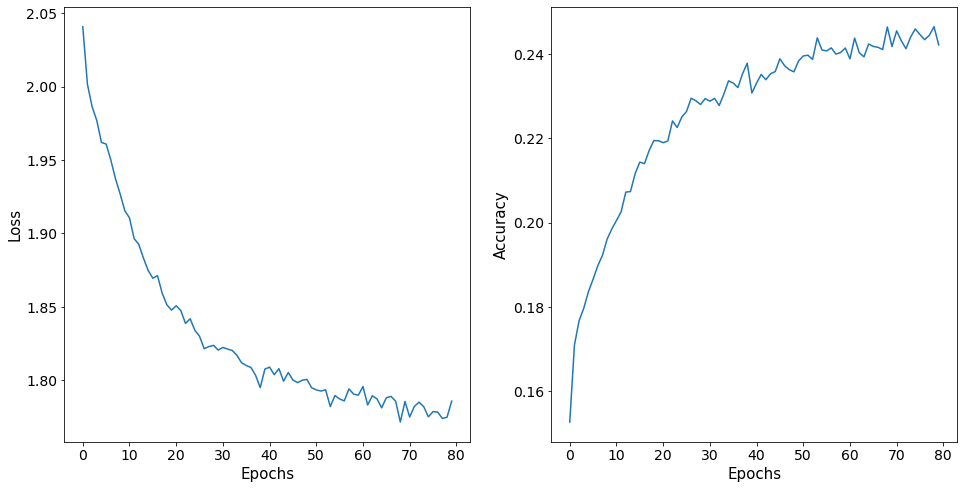

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.plot(np.arange(len(loss_cpc)), loss_cpc)
ax1.set_xlabel('Epochs', fontsize=15)
ax1.set_ylabel('Loss', fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.plot(np.arange(len(acc_cpc)), acc_cpc)
ax2.set_xlabel('Epochs', fontsize=15)
ax2.set_ylabel('Accuracy', fontsize=15)
ax2.tick_params(axis='both', which='major', labelsize=14)
#fig.suptitle('CPC training metrics', fontsize=16)
loss_cpc[-1], acc_cpc[-1]

In [40]:
# save_model(model, optimizer, loss_cpc, [acc_cpc], CHECKPOINT_PATH + checkpoint_name)

## Training - Downstream

Actual training of the downstream model(s).

### Aliveness

In [62]:
downstream_model = AlivenessEstimator(128, 1).to(DEVICE)
downstream_optimizer = torch.optim.Adam(downstream_model.parameters())
downstream_loss = nn.MSELoss()

In [63]:
loss_hist_downstream = []
second_metric_hist_downstream = []

downstream_val_mse = []
downstream_val_mae = []
downstream_val_r2 = []
best = 99999999999999
checkpoint_name = 'ds_checkpoint_alive_hyperopt'

In [64]:
if False: # faster than commenting out - switch to True to load
# if True:
    loaded_state = load_model(downstream_model, downstream_optimizer, CHECKPOINT_PATH_DOWNSTREAM + checkpoint_name)
    loss_hist_downstream = loaded_state['loss']
    second_metric_hist_downstream = loaded_state['metrics'][0]
    best = loaded_state['metrics'][1][0]
    downstream_val_mse = loaded_state['metrics'][2]
    downstream_val_mae = loaded_state['metrics'][3]
    downstream_val_r2 = loaded_state['metrics'][4]
    del loaded_state

In [72]:
for epoch in range(10):
    l, a = train_estimator(model, downstream_model, 'lifespan', downstream_optimizer, downstream_loss, epoch, train_loader, 128)
    loss_hist_downstream.append(l)
    second_metric_hist_downstream.append(a)
    
    mse, mae, r2 = validate(model, downstream_model, 'lifespan', test_loader, 128)
    downstream_val_mse.append(mse)
    downstream_val_mae.append(mae)
    downstream_val_r2.append(r2)
    print('val: \tMAE: {:.2f}\tMSE: {:.6f}\tR2: {:.6f}'.format(mae, mse, r2))
    
    # checkpoint
#     if mse < best:
#         best = mse
#         save_model(downstream_model, downstream_optimizer, loss_hist_downstream, 
#                    [second_metric_hist_downstream, [best], downstream_val_mse, downstream_val_mae, downstream_val_r2],
#                    CHECKPOINT_PATH_DOWNSTREAM + checkpoint_name)

Epoch: 0	MAE: 414.48	MSE: 390107.462371
val: 	MAE: 276.66	MSE: 199259.093669	R2: -0.097567
Epoch: 1	MAE: 83.99	MSE: 15761.757700
val: 	MAE: 278.01	MSE: 198067.393672	R2: -0.091003
Epoch: 2	MAE: 301.27	MSE: 277187.319366
val: 	MAE: 279.37	MSE: 196922.925796	R2: -0.084699
Epoch: 3	MAE: 221.96	MSE: 63922.719086
val: 	MAE: 280.63	MSE: 195922.704173	R2: -0.079189
Epoch: 4	MAE: 227.87	MSE: 121172.761941
val: 	MAE: 281.96	MSE: 194932.345362	R2: -0.073734
Epoch: 5	MAE: 87.79	MSE: 10084.563103
val: 	MAE: 283.32	MSE: 193982.790370	R2: -0.068504
Epoch: 6	MAE: 567.30	MSE: 825580.100611
val: 	MAE: 284.66	MSE: 193108.810434	R2: -0.063690
Epoch: 7	MAE: 644.87	MSE: 826968.232110
val: 	MAE: 285.90	MSE: 192340.672935	R2: -0.059459
Epoch: 8	MAE: 131.75	MSE: 23078.924005
val: 	MAE: 287.14	MSE: 191604.416669	R2: -0.055403
Epoch: 9	MAE: 689.91	MSE: 810897.240729
val: 	MAE: 288.29	MSE: 190960.270275	R2: -0.051855


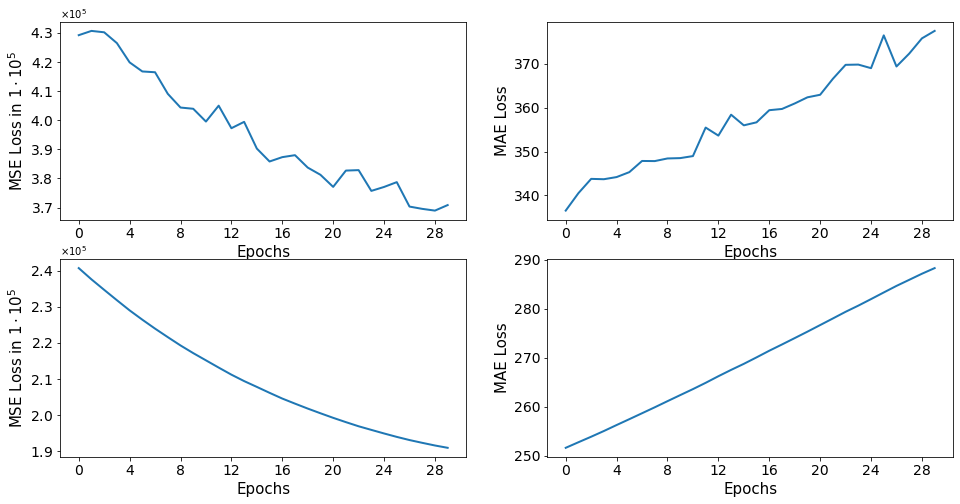

In [73]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8))
ax1.plot(np.arange(len(loss_hist_downstream)), loss_hist_downstream, linewidth=2)
ax1.set_xlabel('Epochs', fontsize=15)
ax1.set_ylabel('MSE Loss in $1 \cdot 10^5$', fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useOffset=True, useMathText=True)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.plot(np.arange(len(second_metric_hist_downstream)), second_metric_hist_downstream, linewidth=2)
ax2.set_xlabel('Epochs', fontsize=15)
ax2.set_ylabel('MAE Loss', fontsize=15)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax3.plot(np.arange(len(downstream_val_mse)), downstream_val_mse, linewidth=2)
ax3.set_xlabel('Epochs', fontsize=15)
ax3.set_ylabel('MSE Loss in $1 \cdot 10^5$', fontsize=15)
ax3.tick_params(axis='both', which='major', labelsize=14)
ax3.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useOffset=True, useMathText=True)
ax3.xaxis.set_major_locator(MaxNLocator(integer=True))
ax4.plot(np.arange(len(downstream_val_mae)), downstream_val_mae, linewidth=2)
ax4.set_xlabel('Epochs', fontsize=15)
ax4.set_ylabel('MAE Loss', fontsize=15)
ax4.tick_params(axis='both', which='major', labelsize=14)
ax4.xaxis.set_major_locator(MaxNLocator(integer=True))
#fig.suptitle('Aliveness estimation training metrics', fontsize=16)
plt.show()

### Circadian

In [110]:
downstream_model = CircadianEstimator(64, 1).to(DEVICE)
downstream_optimizer = torch.optim.Adam(downstream_model.parameters())
downstream_loss = nn.MSELoss()

In [111]:
loss_hist_downstream = []
second_metric_hist_downstream = []

downstream_val_mse = []
downstream_val_mae = []
downstream_val_r2 = []
best = 99999999999999
checkpoint_name = 'ds_checkpoint_circadian_hyperopt'

In [ ]:
if False: # faster than commenting out - switch to True to load
# if True:
    loaded_state = load_model(downstream_model, downstream_optimizer, CHECKPOINT_PATH_DOWNSTREAM + checkpoint_name)
    loss_hist_downstream = loaded_state['loss']
    second_metric_hist_downstream = loaded_state['metrics'][0]
    best = loaded_state['metrics'][1][0]
    downstream_val_mse = loaded_state['metrics'][2]
    downstream_val_mae = loaded_state['metrics'][3]
    downstream_val_r2 = loaded_state['metrics'][4]
    del loaded_state

In [ ]:
for epoch in range(5):
    l, a = train_estimator(model, downstream_model, 'circadian', downstream_optimizer, downstream_loss, epoch, train_loader, 64)
    loss_hist_downstream.append(l)
    second_metric_hist_downstream.append(a)
    
    mse, mae, r2 = validate(model, downstream_model, 'circadian', test_loader)
    downstream_val_mse.append(mse)
    downstream_val_mae.append(mae)
    downstream_val_r2.append(r2)
    print('val: \tMAE: {:.2f}\tMSE: {:.6f}\tR2: {:.6f}'.format(mae, mse, r2))
    
    # checkpoint
    if mse < best:
        best = mse
        save_model(downstream_model, downstream_optimizer, loss_hist_downstream, 
                   [second_metric_hist_downstream, [best], downstream_val_mse, downstream_val_mae, downstream_val_r2],
                   CHECKPOINT_PATH_DOWNSTREAM + checkpoint_name)

(tensor(2.7429e-05), tensor(0.0037))

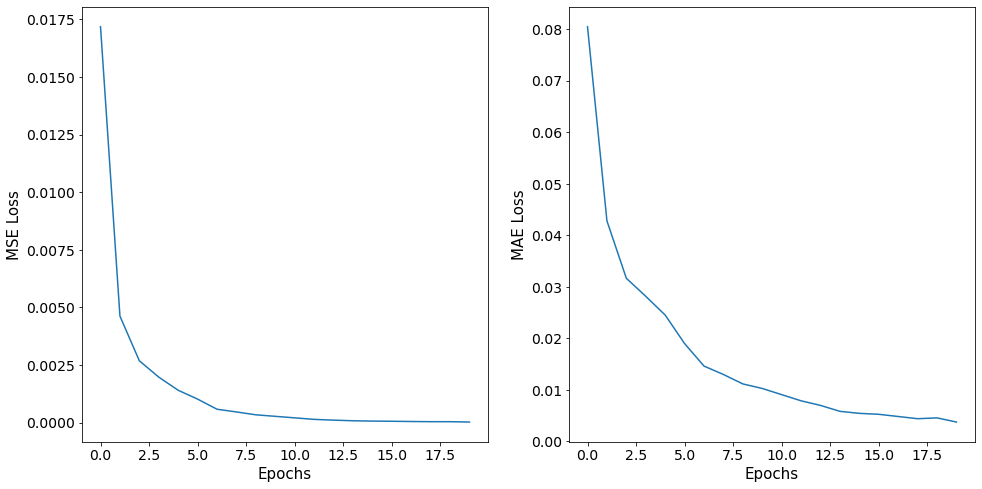

In [142]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8))
ax1.plot(np.arange(len(loss_hist_downstream)), loss_hist_downstream, linewidth=2)
ax1.set_xlabel('Epochs', fontsize=15)
ax1.set_ylabel('MSE Loss in $1 \cdot 10^5$', fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useOffset=True, useMathText=True)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.plot(np.arange(len(second_metric_hist_downstream)), second_metric_hist_downstream, linewidth=2)
ax2.set_xlabel('Epochs', fontsize=15)
ax2.set_ylabel('MAE Loss', fontsize=15)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax3.plot(np.arange(len(downstream_val_mse)), downstream_val_mse, linewidth=2)
ax3.set_xlabel('Epochs', fontsize=15)
ax3.set_ylabel('MSE Loss in $1 \cdot 10^5$', fontsize=15)
ax3.tick_params(axis='both', which='major', labelsize=14)
ax3.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useOffset=True, useMathText=True)
ax3.xaxis.set_major_locator(MaxNLocator(integer=True))
ax4.plot(np.arange(len(downstream_val_mae)), downstream_val_mae, linewidth=2)
ax4.set_xlabel('Epochs', fontsize=15)
ax4.set_ylabel('MAE Loss', fontsize=15)
ax4.tick_params(axis='both', which='major', labelsize=14)
ax4.xaxis.set_major_locator(MaxNLocator(integer=True))
#fig.suptitle('Circadian estimation training metrics', fontsize=16)
plt.show()

# Evaluation

In [218]:
validate(model, downstream_model, 'lifespan', test_loader)

(211856.99906191442, 267.2218940078569, -0.16695934342552476)

In [143]:
validate(model, downstream_model, 'circadian', test_loader)

(0.005531955018373718, 0.03355639705082996, -0.2426577293260952)

The mean life time of an individual is 18 steps. Let's compare our validation to this baseline as well as to always predicting zero to get a feeling if our prediction is any good.

In [84]:
def val_baselines(data_loader, downstream_key):
    baseline_mse_0 = []
    baseline_mae_0 = []
    baseline_mse_mean = []
    baseline_mae_mean = []
    
    baseline_0 = torch.zeros([8])
    baseline_mean = torch.as_tensor(np.array([18 * 2] * 8))

    #time_steps_to_check = [1] + [int(1680 / x) for x in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]]
    time_steps_to_check = range(1680)
    
    # for R²
    n = 1680 * BATCH_SIZE * len(data_loader) # 35 days á 48 steps x samples per batch x num batches
    sum_of_errors = 0
    y_sum = 0
    y_sq_sum = 0

    for batch_idx, (x, y) in enumerate(data_loader):
        y = y[downstream_key]
        
        inner_mse_0 = []
        inner_mae_0 = []
        inner_mse_mean = []
        inner_mae_mean = []
        
        for step in time_steps_to_check:
            y_t = y[:,step]
            inner_mse_0.append(F.mse_loss(baseline_0, y_t, reduction='mean'))
            inner_mae_0.append(F.l1_loss(baseline_0, y_t, reduction='mean'))
            inner_mse_mean.append(F.mse_loss(baseline_mean, y_t, reduction='mean'))
            inner_mae_mean.append(F.l1_loss(baseline_mean, y_t, reduction='mean'))
            # for R²
            sum_of_errors += torch.sum(torch.pow(y_t, 2)).item()
            y_sum += torch.sum(y_t).item()
            y_sq_sum += torch.sum(torch.pow(y_t, 2)).item()

        baseline_mse_0.append(torch.mean(torch.tensor(inner_mse_0, dtype=torch.float64)))
        baseline_mae_0.append(torch.mean(torch.tensor(inner_mae_0, dtype=torch.float64)))
        baseline_mse_mean.append(torch.mean(torch.tensor(inner_mse_mean, dtype=torch.float64)))
        baseline_mae_mean.append(torch.mean(torch.tensor(inner_mae_mean, dtype=torch.float64)))

    print (
        torch.mean(torch.tensor(baseline_mse_0, dtype=torch.float64)).item(),
        torch.mean(torch.tensor(baseline_mae_0, dtype=torch.float64)).item(),
        torch.mean(torch.tensor(baseline_mse_mean, dtype=torch.float64)).item(),
        torch.mean(torch.tensor(baseline_mae_mean, dtype=torch.float64)).item(),
        1 - sum_of_errors / (y_sq_sum - (y_sum ** 2) / n)
    )
    return baseline_mae_0, baseline_mae_mean

In [85]:
mae_0, mae_mean = val_baselines(test_loader, 'circadian')

0.005348057218212581 0.030111701201663822 1293.837305570705 35.96988829879843 -0.20415325203111068


<AxesSubplot:>

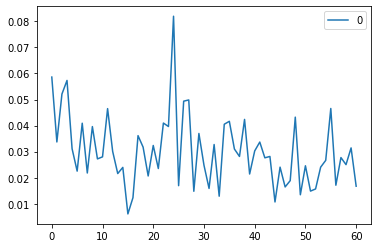

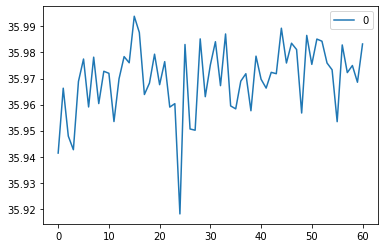

In [65]:
pd.DataFrame(mae_0).plot()
pd.DataFrame(mae_mean).plot()

## CNNs

What did our CNN learn? How do the weights look?

In [119]:
# model = CPC(N_STEPS, BATCH_SIZE, hidden_size=64, context_size=128)
# load_model(model, optimizer, CHECKPOINT_PATH + 'cpc_checkpoint_nbh_64_128.pt')
model.to('cpu')
cnn_params = model.g_enc[0].weight.data

print(cnn_params.shape)

torch.Size([32, 1, 1, 2443])


<AxesSubplot:>

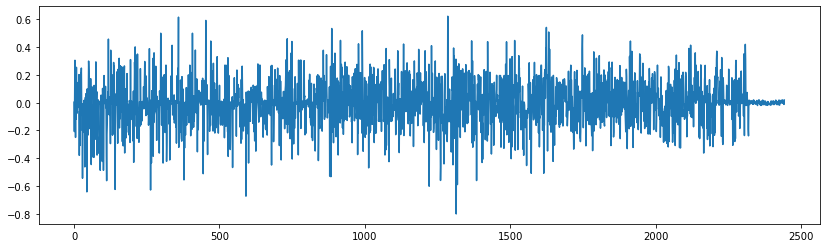

In [120]:
pd.DataFrame(cnn_params[0].squeeze().numpy()).plot(figsize=(14,4), legend=False)

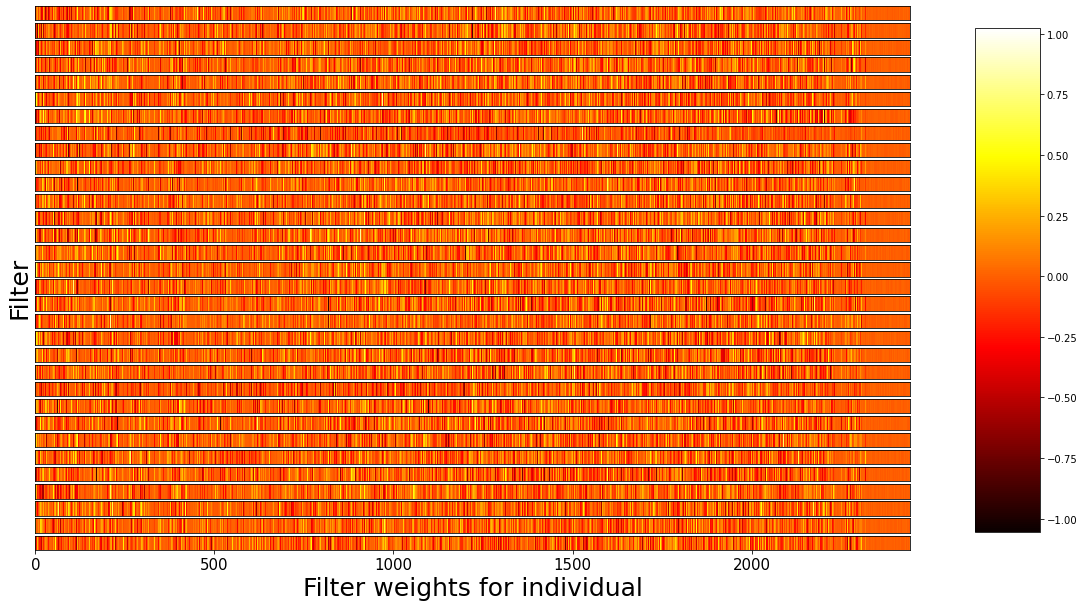

In [140]:
fig, axes = plt.subplots(32, 1, figsize=(18, 10))
vmin = cnn_params.min().item()
vmax = cnn_params.max().item()
for i in range(len(axes)):
    im = axes[i].imshow(cnn_params.squeeze().numpy()[i:i+1], cmap='hot', interpolation='nearest', aspect='auto', vmin=vmin, vmax=vmax)
    axes[i].tick_params(labelcolor='none', bottom=False, left=False, labelbottom=False, labelleft=False)
axes[-1].tick_params(axis='both', bottom=True, labelbottom=True, labelcolor='black')
axes[-1].set_xlabel('Filter weights for individual', fontsize=25)
axes[16].set_ylabel('Filter', fontsize=25)
axes[-1].tick_params(axis='x', which='major', labelsize=15)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
# fig.suptitle('CNN kernel weights heatmap', fontsize=24)

plt.show()

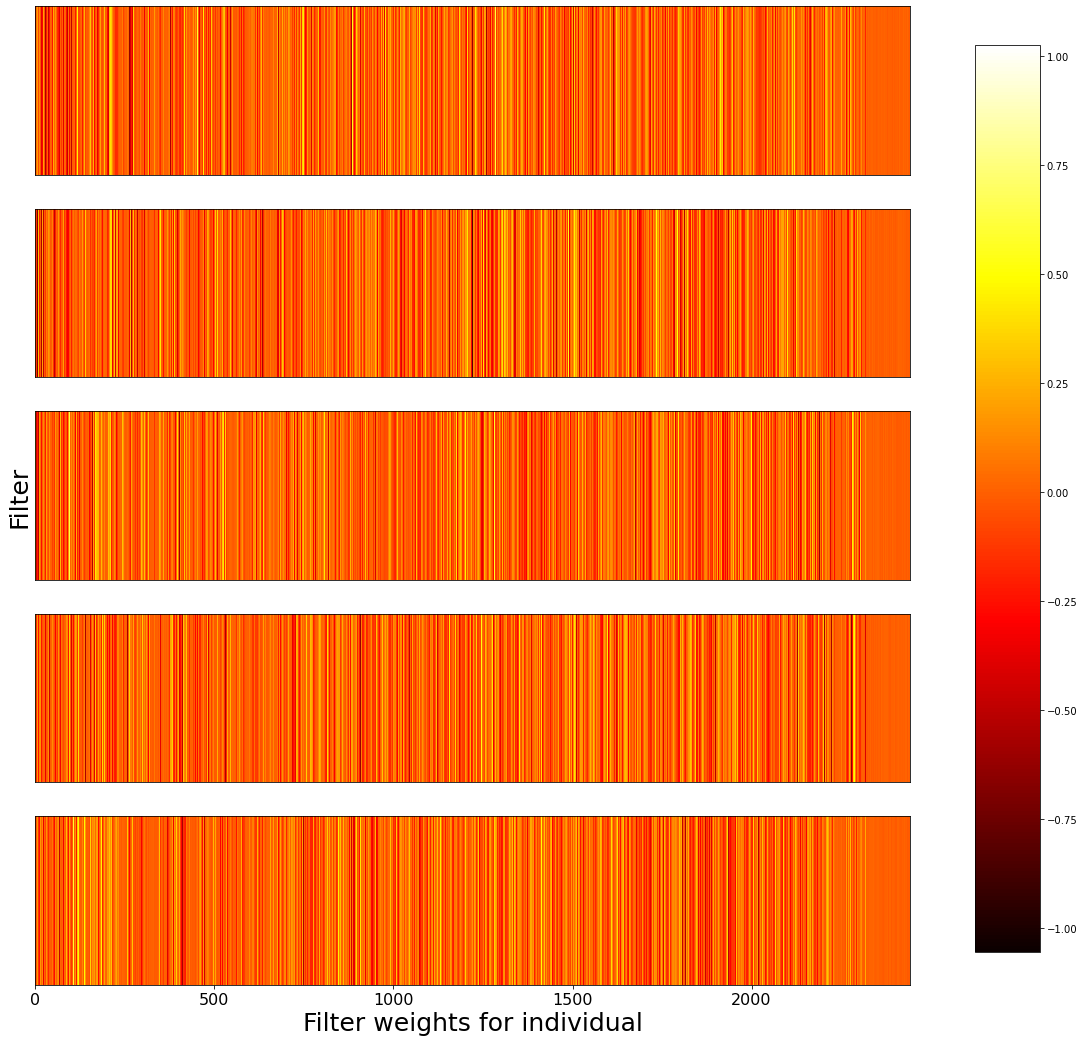

In [139]:
fig, axes = plt.subplots(5, 1, figsize=(18, 18))
vmin = cnn_params.min().item()
vmax = cnn_params.max().item()
for i in range(len(axes)):
    im = axes[i].imshow(cnn_params.squeeze().numpy()[i:i+1], cmap='hot', interpolation='nearest', aspect='auto', vmin=vmin, vmax=vmax)
    axes[i].tick_params(labelcolor='none', bottom=False, left=False, labelbottom=False, labelleft=False)
axes[-1].tick_params(axis='both', bottom=True, labelbottom=True, labelcolor='black')
axes[-1].set_xlabel('Filter weights for individual', fontsize=25)
axes[len(axes) // 2].set_ylabel('Filter', fontsize=25)
axes[-1].tick_params(axis='x', which='major', labelsize=16)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
# fig.suptitle('CNN kernel weights heatmap for kernels 1-10', fontsize=30)

plt.show()

In [229]:
cnn_params.squeeze().numpy()[0:1,:10]

array([[ 0.00360457, -0.01552613,  0.00916442, -0.17429578, -0.07537768,
        -0.36424673,  0.339594  , -0.18702567, -0.44637766,  0.10080433]],
      dtype=float32)

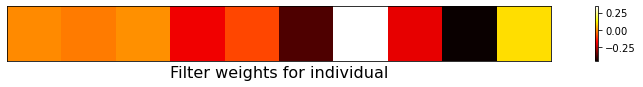

In [230]:
fig, ax = plt.subplots(figsize=(16, 1))
im = ax.imshow(cnn_params.squeeze().numpy()[0:1,:10], cmap='hot', interpolation='nearest', aspect='equal')
ax.tick_params(labelcolor='none', bottom=False, left=False, labelbottom=False, labelleft=False)
ax.set_xlabel('Filter weights for individual', fontsize=16)
fig.colorbar(im)
fig.show()

In [ ]:
model.to(DEVICE)

In [109]:
gc.collect()
torch.cuda.empty_cache()
# torch.cuda.memory_summary(DEVICE)
int(torch.cuda.memory_allocated(DEVICE) / 1000 / 1000)

7